In [1]:
import pandas as pd
import numpy as np
#%matplotlib nbagg
import matplotlib.pyplot as plt
plt.rc("font", size=15)

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 5, 5


plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

In [2]:
import json
import seaborn as sns
with open(adresse+"input/dico_sentiment.json") as json_file:
        dico_sentiment = json.load(json_file)

reverse_dico_sentiment={dico_sentiment[s]:s for s in dico_sentiment.keys()}

# Model evaluation

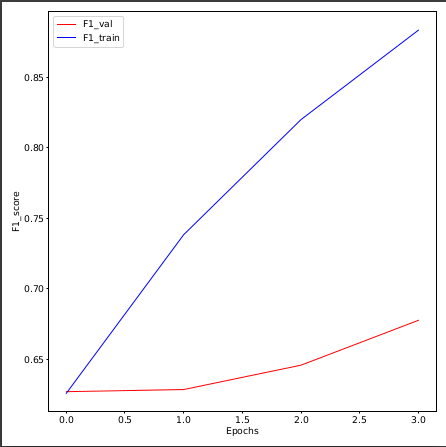

In [6]:
from IPython.display import Image

Image(adresse+"/src/f1.png")

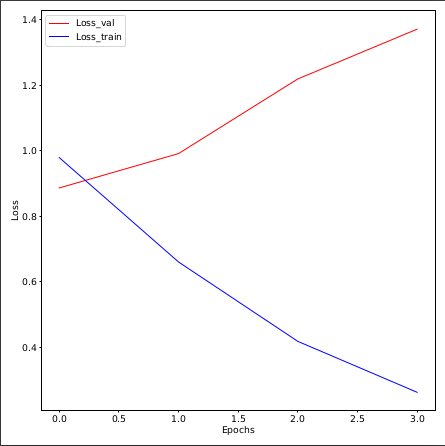

In [4]:
Image(adresse+"/src/loss.png")

Very obvious overfitting. But I did already a lot to reduce the overfitting and still couldn't get it disapear. But let's see what this overfitting means.

# Test set evaluation

In [5]:
test_df_eval=pd.read_csv(adresse+"predictions/test_eval.csv")
test_df=pd.read_csv(adresse+"input/evaluating/test.csv")

In [7]:
X=np.array(test_df_eval[list(test_df_eval)[1:-1]])
dico_color={0:'grey',1:'red',2:'green',3:'blue',4:'black'}
list_col=[dico_color[v] for v in list(test_df.emotion)]
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='joy')
grey_patch = mpatches.Patch(color='grey', label='sadness')
green_patch = mpatches.Patch(color='green', label='surprise')
blue_patch = mpatches.Patch(color='blue', label='anger')
black_patch = mpatches.Patch(color='black', label='neutral')
list_patches=[red_patch,grey_patch,green_patch,blue_patch,black_patch]

In [8]:
from sklearn import manifold
X_TSNE=manifold.TSNE(n_jobs=-1).fit_transform(X)

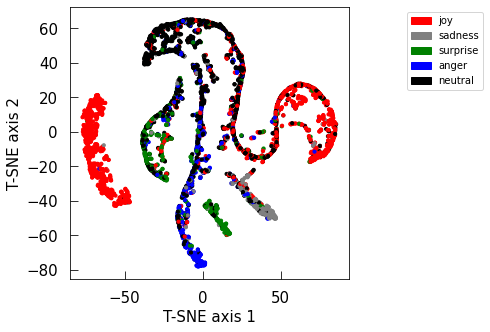

In [10]:
plt.scatter(X_TSNE[:,0],X_TSNE[:,1],color=list_col,s=10)
plt.legend(handles=list_patches,fontsize=10,bbox_to_anchor=(1, 0.5, 0.5, 0.5))
plt.xlabel("T-SNE axis 1")
plt.ylabel("T-SNE axis 2")
plt.show()

Overall it is not that bad, the overfitting is probably mainly coming from those neutral sentences that are polluting our classifier results. But in the end we have nice/ok cluster by emotion. Even neutral sentences seem to be group, at least for some, in the middle upper part of the plot.

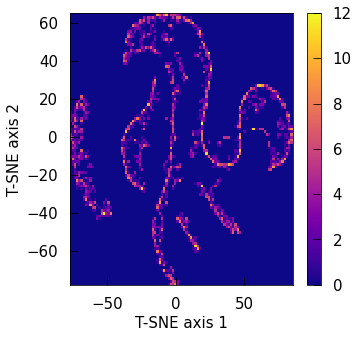

In [13]:
plt.hist2d(X_TSNE[:,0],X_TSNE[:,1],bins=100,cmap='plasma')
plt.colorbar()
plt.xlabel("T-SNE axis 1")
plt.ylabel("T-SNE axis 2")
plt.show()

Just to have an idea of the number of point that those clusters represent.

In [14]:
list_test_eval=[]
for i in test_df_eval.index:
    list_test_eval.append(np.argmax(list(test_df_eval.iloc[i][1:-1])))

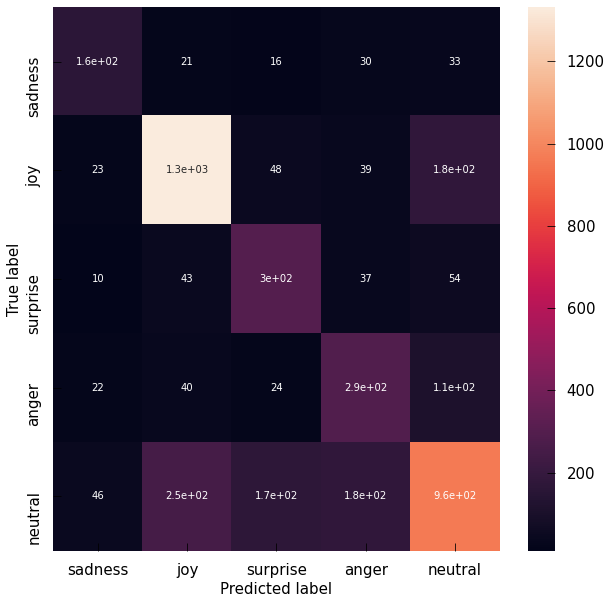

In [15]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
confusion_mc_c = confusion_matrix(list(test_df['emotion']), list_test_eval)
df_cm_c = pd.DataFrame(confusion_mc_c,
                       index=[reverse_dico_sentiment[i] for i in range(len(reverse_dico_sentiment))],
                             columns=[reverse_dico_sentiment[i] for i in range(len(reverse_dico_sentiment))])

plt.figure(figsize=(10,10))
sns.heatmap(df_cm_c, annot=True, annot_kws={"size": 10})
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()
plt.close()


Text(678.9999999999999, 0.5, 'True label')

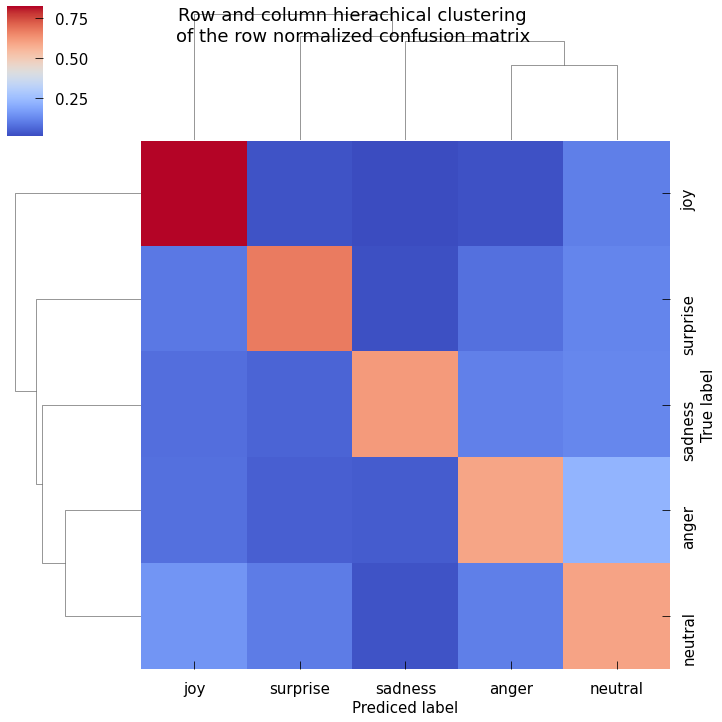

In [21]:
confusion_mc_c_norm=np.zeros(confusion_mc_c.shape,dtype='f')
k=0
for v in confusion_mc_c:
    confusion_mc_c_norm[k]=v/sum(v)
    k+=1
df_cm_c_norm = pd.DataFrame(confusion_mc_c_norm,
                       index=[reverse_dico_sentiment[i] for i in range(len(reverse_dico_sentiment))],
                             columns=[reverse_dico_sentiment[i] for i in range(len(reverse_dico_sentiment))])


a=sns.clustermap(df_cm_c_norm,z_score=None,row_cluster=True,col_cluster=True,method='ward',cmap='coolwarm')
a.fig.suptitle("Row and column hierachical clustering\nof the row normalized confusion matrix")
b=a.ax_heatmap
b.set_xlabel("Prediced label")
b.set_ylabel("True label")


It doesn't really seems that is any structure in how the model sees the different emotions.

In [26]:
cr=pd.DataFrame(classification_report(list(test_df['emotion']), list_test_eval,output_dict=True))

del cr["accuracy"]
cr.columns=[reverse_dico_sentiment[i] for i in range(len(reverse_dico_sentiment))]+["macro avg","weighted avg"]

In [27]:
cr

,sadness,joy,surprise,anger,neutral,macro avg,weighted avg
precision,0.615970,0.790974,0.539568,0.506066,0.719311,0.634378,0.697768
recall,0.618321,0.822730,0.675676,0.597137,0.599875,0.662748,0.689991
f1-score,0.617143,0.806540,0.600000,0.547842,0.654187,0.645142,0.690621
support,262.000000,1619.000000,444.000000,489.000000,1602.000000,4416.000000,4416.000000


Joy is really sticking out, but we could already see that in the T-SNE plot